## AI FASHION CHEK
Fashion GANS is a innovative way to generate unique dress designs using GANs algorithm

## Utils

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile

file_name = "./drive/MyDrive/FYP2/Batches.zip"
target_directory = "./drive/MyDrive/FYP2/"

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path=target_directory)
    print('Extraction complete.')

In [ ]:
torch.cuda.empty_cache()

# Data Preprocessing and Augmentation
This section involves preparing the input images for training by resizing and augmenting them.

## Image Preprocessing
The **preprocess_image** function resizes images to 512x512 pixels using Anti-Aliasing.

## Augmentation
Augmentation enhances the dataset using TensorFlow's **ImageDataGenerator** with techniques like rotation, shifting, shear, zoom, and flipping.

### Process Overview


1.   Initialize **ImageDataGenerator** with augmentation settings.
2.   For each image in the input directory:
        *   Read and preprocess the image.
        *   Generate augmented variations.
        *   Save augmented images to the output directory.

The total count of added augmented images is printed.

**Note**: Augmentation diversifies data for better model training.







In [ ]:

import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_dir = "./segmented_images/"
output_dir = "./augmented_images"

# Define the image preprocessing function
def preprocess_image(image):
    # Resize the image to 512x512
    img = image.resize((512, 512), Image.ANTIALIAS)
    return img

# Create an image data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize a counter for the total number of augmented images
total_augmented_images = 0

# Loop over all the image files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):

        # Read the image file
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        # Perform image preprocessing
        preprocessed_image = preprocess_image(image)

        # Generate augmented images using the data generator
        batch = np.expand_dims(preprocessed_image, axis=0)
        aug_iter = datagen.flow(batch, batch_size=1)
        augmented_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

        # Save the preprocessed and augmented images to the output directory
        for i, augmented_image in enumerate(augmented_images):
            output_filename = filename.split(".")[0] + f"_{i}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, augmented_image)

            total_augmented_images += 1  # Increment the counter

# Print the number of augmented images added
print(f"Total augmented images added: {total_augmented_images}")

# File Renaming for Segmentation
This section outlines the process of renaming files to prepare for segmentation.

## Renaming Process
Files in the input directory are renamed to ensure consistent organization for the segmentation process.

## Segmentation Preparation
1. Files in the input directory are listed and sorted.
2. An output directory is created.
3. Valid image extensions (jpg, jpeg, png, webp, gif) are defined.

## Renaming Loop
For each file:

*   If the file has a valid image extension:
    * A new name is generated using an index and original extension.
    * The file is renamed and moved to the output directory.

## Summary
The total count of renamed files is displayed, marking completion.







In [ ]:
import os

# Define the input and output directory paths
input_dir = "./Batches/Batch_14/"
output_dir = "./renamed_images/"

# Get a list of all files in the input directory and sort them
files = sorted(os.listdir(input_dir))

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Counter for renamed files
renamed_count = 0

# List of valid image extensions
valid_extensions = ["jpg", "jpeg", "png", "webp", "gif"]

# Loop through the files and rename all files
for i, file in enumerate(files):
    # Get the file extension (excluding the dot) from the filename
    file_extension = os.path.splitext(file)[1][1:].lower()

    # Check if the file has a valid image extension
    if file_extension in valid_extensions:
        # Create the new file name with the index and original extension
        new_file_name = str(i + 10997) + "." + file_extension
        # Construct the paths for the old and new files
        old_path = os.path.join(input_dir, file)
        new_path = os.path.join(output_dir, new_file_name)
        # Rename the file using os.rename and move it to the output directory
        try:
            os.rename(old_path, new_path)
            renamed_count += 1
        except Exception as e:
            print(f"Error renaming {old_path}: {str(e)}")

# Print the total number of renamed files
print(f"Total files renamed: {renamed_count}")


# Image Segmentation with U2NET
This section demonstrates image segmentation using the U2NET model.

## Initialization and Configuration
The U2NET model is initialized and configured for image segmentation. Input images are loaded from the specified directory, and segmentation results are saved to an output directory.

## Segmentation Process

1. The U2NET model is loaded from a pre-trained checkpoint.
2. A palette for visualization is generated based on the number of classes.
3. Images are loaded from the input directory and preprocessed.
4. Image tensors are passed through the U2NET model.
5. Segmentation results are processed, and an output image is created.
6. If desired, a palette is applied for visualization.
7. Segmented images are saved in the output directory.

## Summary

The code demonstrates segmenting images using U2NET and saving the segmented outputs. It showcases the power of semantic segmentation for image analysis and manipulation.

In [ ]:
import os

from tqdm import tqdm
from PIL import Image
import numpy as np

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from segmentation.data.base_dataset import Normalize_image
from segmentation.utils.saving_utils import load_checkpoint_mgpu

from segmentation.networks import U2NET

device = "cuda"

image_dir = "./renamed_images"
result_dir = "./output_images"
checkpoint_path =  "./cloth_segm_u2net_latest.pth"
do_palette = True


def get_palette(num_cls):
    """Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i += 1
            lab >>= 3
    return palette


transforms_list = []
transforms_list += [transforms.ToTensor()]
transforms_list += [Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

net = U2NET(in_ch=3, out_ch=4)
net = load_checkpoint_mgpu(net, checkpoint_path)
net = net.to(device)
net = net.eval()

palette = get_palette(4)

images_list = sorted(os.listdir(image_dir))
pbar = tqdm(total=len(images_list))
for image_name in images_list:
    img = Image.open(os.path.join(image_dir, image_name)).convert("RGB")
    image_tensor = transform_rgb(img)
    image_tensor = torch.unsqueeze(image_tensor, 0)

    output_tensor = net(image_tensor.to(device))
    output_tensor = F.log_softmax(output_tensor[0], dim=1)
    output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_arr = output_tensor.cpu().numpy()

    output_img = Image.fromarray(output_arr.astype("uint8"), mode="L")
    if do_palette:
        output_img.putpalette(palette)
    image_name, extension = os.path.splitext(image_name)
    output_img.save(os.path.join(result_dir, image_name + ".png"))


    pbar.update(1)

pbar.close()

# Restoring Segmented Masks
This section focuses on restoring green regions in segmented images by applying masks.

## Process Overview

1. Paths for input, output, and restored image directories are defined.
2. The directory for restored images is created if absent.
3. For each file in the input directory:
      * The original color photo and corresponding segmented mask are loaded.
      * Green regions are identified using the mask.
      * The green regions are extracted from the original image.
      * The restored image is saved in the restored images directory.

## Restoring Green Regions

1. Original image and segmented mask are loaded.
2. Green color thresholds are defined.
3. A green mask is created by thresholding the green pixels in the segmented mask.
4. Green regions are extracted using bitwise operations.
5. The restored image is saved in the restored images directory.






In [ ]:
import os
import cv2
import numpy as np

# Define the paths for the input, output, and restored images directories
# input_dir = "./drive/MyDrive/FYP/Sample_Preprocess_Output"
input_dir = "./renamed_images/"
output_dir = "./output_images/"
restored_dir = "./restored_images/"

# Create the restored images directory if it doesn't exist
if not os.path.exists(restored_dir):
    os.makedirs(restored_dir)

# Loop through all files in the input directory
for filename in os.listdir(input_dir):
    # Load the original color photo and the corresponding mask image
    original_image = cv2.imread(os.path.join(input_dir, filename))
    mask_filename = os.path.splitext(filename)[0] + ".png"
    segmented_mask = cv2.imread(os.path.join(output_dir, mask_filename))

    # Define the lower and upper threshold values for the green color
    lower_green = np.array([0, 128, 128])
    upper_green = np.array([0, 128, 128])

    # Create the green mask by thresholding the green pixels in the segmented mask
    green_mask = cv2.inRange(segmented_mask, lower_green, upper_green)

    # Apply the green mask to the original image using the bitwise_and function
    green_regions = cv2.bitwise_and(original_image, original_image, mask=green_mask)

    # Save the restored image in the restored images directory
    restored_filename = os.path.splitext(filename)[0] + "_restored.jpg"
    restored_path = os.path.join(restored_dir, restored_filename)
    cv2.imwrite(restored_path, green_regions)

# Model Definition

## Convolution Function
The Convolution_func function generates a convolutional layer with optional batch normalization.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Self maden Convolution function
def Convolution_func(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels,
                           kernel_size, stride, padding, bias=False)

    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))

    # using Sequential container
    return nn.Sequential(*layers)


# Discriminator Class
The Discriminator class initializes a discriminator module for GANs.

## Architecture
The discriminator consists of multiple convolutional layers with increasing dimensions:

1. **Input**: 3-channel images.
2. **conv1**: 2D convolutional layer, no batch normalization.
3. **conv2**: Convolutional layer with increased channels.
4. **conv3**: Further increased channels.
5. **conv4**: Channels doubled again.
6. **conv5**: Channels quadrupled.
7. **last**: Final convolutional layer with single channel output.

## Forward Pass

1. Leaky ReLU activation is applied between convolutional layers.
2. The forward pass progresses through layers to produce logits.
3. The output tensor represents the discriminator's decision.

In [4]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        """
        Discriminator Module Initialization
        """
        super(Discriminator, self).__init__()

        # Layers definition
        self.conv_dim = conv_dim
        # 64x64 input
        self.conv1 = Convolution_func(3, conv_dim, 4, batch_norm=False)
        # first layer, no batch_norm
        # 32x32 out
        self.conv2 = Convolution_func(conv_dim, conv_dim*2, 4)
        # 16x16 out
        self.conv3 = Convolution_func(conv_dim*2, conv_dim*4, 4)
        # 8x8 out
        self.conv4 = Convolution_func(conv_dim*4, conv_dim*8, 4)
        # 4x4 out
        self.conv5 = Convolution_func(conv_dim*8, conv_dim*16, 4)
        # 2*2 out
        self.last = Convolution_func(conv_dim*16,1,4,batch_norm=False)

    def forward(self, x):
        """
        Forward Propagation Pass
        :X -> Input
        :return -> Discriminator logits
        """
        # Forward pass
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.last(out)

        return out
        return x


## Deconvolution Function
The Deconvolution_func function generates a deconvolutional layer with optional batch normalization.

In [5]:
# Deconvolution Function
def Deconvolution_func(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    conv_transpose = nn.ConvTranspose2d(in_channels,out_channels, kernel_size, stride,padding,bias=False)
    # append conv layer
    layers.append(conv_transpose)
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    # using Sequential container
    return nn.Sequential(*layers)


# Generator Class
The Generator class is responsible for generating images in GANs.

## Initialization
The generator takes input latent vectors of size **z_size** and uses **conv_dim** for convolutional layer depths.

## Architecture
1. A fully-connected layer (fc) converts the latent vector to a feature map.
2. Transpose convolution layers (t_conv) upsample the feature map to create images.

## Forward Pass
1. Input latent vectors are passed through the fully-connected layer.
2. The resulting feature map is reshaped.
3. Leaky ReLU activations are applied between transpose convolutional layers.
4. The final layer employs a tanh activation to output images.

In [6]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=64):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last*
        transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*16*2*2)

        # transpose conv layers
        self.t_conv1 = Deconvolution_func(conv_dim*16, conv_dim*8, 4)
        self.t_conv2 = Deconvolution_func(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = Deconvolution_func(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = Deconvolution_func(conv_dim*2, conv_dim, 4)
        self.t_conv5 = Deconvolution_func(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward Propagation Pass of NN
        :param x -> The input of NN
        :return -> 64x64x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*16, 2, 2) # (batch_size, depth, 2, 2)

        # hidden transpose conv layers + relu
        #try leaky relu here
        out = F.leaky_relu(self.t_conv1(out))
        out = F.leaky_relu(self.t_conv2(out))
        out = F.leaky_relu(self.t_conv3(out))
        out = F.leaky_relu(self.t_conv4(out))
        # last layer + tanh activation
        out = self.t_conv5(out)
        out = F.tanh(out)
        return out

# Conditional Generator Network
This section outlines the architecture of a conditional generator neural network for a conditional Generative Adversarial Network (cGAN).

## Generator Class
The Generator class generates images in a conditional GAN context.

## Initialization
The generator takes input latent vectors of size z_size and uses conv_dim for convolutional layer depths.

## Architecture
1. **Image Encoder**: The generator employs an image encoder to process input images. This consists of convolutional layers followed by batch normalization and leaky ReLU activations.
2. **Noise and Image Concatenation**: The latent noise vector and image features are concatenated for conditioning. The concatenated input is passed through a fully-connected layer (fc).
3. **Transpose Convolution Layers**: The concatenated input is transformed through transpose convolution layers (t_conv) to upsample the feature map and create images.

## Forward Pass
1. If desired, the generator can use an input image for conditioning. Image features are extracted through the image encoder and concatenated with the noise vector.
2. The concatenated input is processed through the fully-connected layer.
3. The feature map is reshaped.
4. Leaky ReLU activations are applied between transpose convolutional layers.
5. The final layer uses a tanh activation to produce output images.

## Usage Notes
1. This architecture enables the generator to produce images conditionally based on an input image.
2. The generator can also generate images without conditioning when **use_image** is set to **False**.

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=64):
        super(Generator, self).__init__()

        self.conv_dim = conv_dim

        # Define layers for processing input image
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Define layers for processing noise and concatenated features
        self.fc = nn.Linear(z_size + conv_dim*2*2*2, conv_dim*16*2*2)

        self.t_conv1 = Deconvolution_func(conv_dim*16, conv_dim*8, 4)
        self.t_conv2 = Deconvolution_func(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = Deconvolution_func(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = Deconvolution_func(conv_dim*2, conv_dim, 4)
        self.t_conv5 = Deconvolution_func(conv_dim, 3, 4, batch_norm=False)

    def forward(self, noise, image=None, use_image=True):
        if use_image and image is not None:
            image_features = self.image_encoder(image)
            image_features = image_features.view(image_features.size(0), -1)
            concat_input = torch.cat((noise, image_features), dim=1)
        else:
            concat_input = noise

        out = self.fc(concat_input)
        out = out.view(-1, self.conv_dim*16, 2, 2)

        out = F.leaky_relu(self.t_conv1(out))
        out = F.leaky_relu(self.t_conv2(out))
        out = F.leaky_relu(self.t_conv3(out))
        out = F.leaky_relu(self.t_conv4(out))
        out = self.t_conv5(out)
        out = F.tanh(out)

        return out

# Normal Initialization of Model Weights
This section describes a function for applying normal distribution-based initialization to convolutional and linear layers within a neural network.

## Function: **weights_init_normal**
The **weights_init_normal** function initializes weights using a normal distribution.

## Initialization Logic
* For convolutional (Conv) and linear (Linear) layers:
  * Weights are initialized using a normal distribution with a mean of 0.0 and a standard deviation of 0.02.

In [7]:
from torch.nn import init
def weights_init_normal(m):
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'Linear' in classname:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


# Model Building
This section illustrates the construction of the discriminator and generator networks with specified hyperparameters.

## Hyperparameters
* **d_conv_dim**: Convolutional layer depth for the discriminator.
* **g_conv_dim**: Convolutional layer depth for the generator.
* **z_size**: Size of the input latent vector.

## Function: **build_network**
The **build_network** function assembles the discriminator and generator networks and initializes their weights using the defined hyperparameters.

## Network Building Process

1. Instantiate a discriminator (**D**) and a generator (**G**) using the given convolutional layer depths and latent vector size.
2. Initialize the weights of both networks using the **weights_init_normal** function.
3. Print the architecture of the discriminator and generator networks.
4. Return the discriminator and generator instances.

In [8]:
import torch

# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 200

def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)

    return D, G
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (last): Sequential(
    (0): Conv2d(1024, 1, 

# Checking GPU Availablity

In [9]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('GPU Not Available.')
else:
    print('GPU Available !')

GPU Available !


# Real Loss Calculation
This section defines a function for calculating the loss related to real data in a GAN training context.

## Function: **real_loss**
The real_loss function computes the loss for real data.

## Loss Calculation
1. For each batch, labels are generated to indicate real data with an optional label smoothing approach.
2. Labels are shifted to the GPU if applicable.
3. Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss) is utilized.
4. The loss is calculated based on the discriminator's output and the labels.

## Parameters
* **D_out**: Discriminator's output tensor.
* **smooth**: A boolean flag indicating whether label smoothing is applied.

In [10]:
# Real Loss
def real_loss(D_out,smooth=False):

    batch_size = D_out.size(0)
    # smoothing labels
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
        # real labels = 1


    # Shifting load to GPU
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

# Fake Loss Calculation
This section defines a function for calculating the loss related to fake (generated) data in a GAN training context.

## Function: **fake_loss**
The fake_loss function computes the loss for generated (fake) data.

## Loss Calculation
1. For each batch, labels are generated to indicate fake data.
2. Labels are shifted to the GPU if applicable.
3. Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss) is utilized.
4. The loss is calculated based on the discriminator's output and the labels.

# Parameters
* **D_out**: Discriminator's output tensor for fake data.

In [11]:
# Fake Loss
def fake_loss(D_out):

    batch_size = D_out.size(0)
    # fake labels = 0
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # Loss Calculations
    loss = criterion(D_out.squeeze(), labels)
    return loss

# Adam Optimizer
This section initializes the Adam optimizers for the discriminator and generator networks in the GAN.

## Hyperparameters
* lr: Learning rate for the optimizers.
* beta1: Exponential decay rate for the first moment estimates.
* beta2: Exponential decay rate for the second moment estimates.

## Optimizer Initialization
* An Adam optimizer is initialized for the discriminator (D) using its parameters and the defined hyperparameters.
* An Adam optimizer is initialized for the generator (G) using its parameters and the same hyperparameters.

In [12]:
import torch.optim as optim

lr = 0.0002
beta1=0.2
beta2=0.999
# default value
# Adam Optimizer for discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# Saving Generator and Discriminator Weights
This section defines a function to save the weights of the generator and discriminator models to specified paths, while also managing model numbering through a log file.

## Function: **saveGD**
The saveGD function facilitates the saving of generator and discriminator weights.

## Saving Process
1. A log file is maintained to track the latest saved model number.
2. If the log file exists:
  * The last saved model number is read from the log file.
  * The log file is updated with the next model number.
3. If the log file doesn't exist, it is created with an initial model number.
4. The generator's weights are saved with a filename indicating the model number.
5. The discriminator's weights are similarly saved.
6. The function provides a path to the folder where the weights are stored.

## Parameters
* **Gmodel**: Generator model instance.
* **Dmodel**: Discriminator model instance.
* **folder_path**: Path to the folder where the weights will be saved.

In [13]:
def saveGD(Gmodel,Dmodel,folder_path):

  log_file = folder_path+"log_file.txt"

  try:
    # Read last saved model number from log file

    with open(log_file,'r') as f:
      log_data  = f.read()
      print("last model num was ", log_data)
      f.close()
    model_num = str(int(log_data)+1)

    with open(log_file,'w') as f:
      f.write(model_num)
      f.close()

  except:
    #create log file
    with open(log_file,'w') as f:
      model_num = str(1)
      f.write(model_num)

  #save generator
  Gname = folder_path + 'G_ckpt'+str(model_num)+".pth"
  torch.save(Gmodel.state_dict(), Gname)

  #save discriminator
  Dname = folder_path + 'D_ckpt'+str(model_num)+".pth"
  torch.save(Dmodel.state_dict(), Dname)


# Data Loading and Transformation
This section defines functions for loading and transforming image data to be used in a neural network.

## Hyperparameters
* **batch_size**: Number of images in each batch.
* **image_size**: Desired size for resizing the images.
* **data_dir**: Path to the directory containing the image dataset.

## Function: get_dataloader
The get_dataloader function prepares a DataLoader object that provides batches of transformed image data for training.

### DataLoader Setup
1. Image transformations are defined using transforms.Compose.
2. The training dataset is created using datasets.ImageFolder with the specified data directory and transformations.
3. A DataLoader instance is generated with shuffled batches of the training dataset.

## Parameters
* **batch_size**: The desired batch size for training data.
* **image_size**: The target image size after resizing.
* **data_dir**: The directory path containing the image dataset.

## Returns
A DataLoader object that provides batched training data.



In [14]:
import torch
from torchvision import datasets
from torchvision import transforms
# path of dataset
data_dir = '/content/drive/My Drive/FYP2/MixData'

#  Defining dataloader
def get_dataloader(batch_size, image_size, data_dir):
    """
    DataLoader Batch the neural network data
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    train_transforms = transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),])

    train_dataset=datasets.ImageFolder(root=data_dir,transform=train_transforms)
    batch_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    return batch_loader

In [15]:
#  hyperparameters definition
batch_size = 32
img_size = 64
data_dir = '/content/drive/My Drive/FYP2/MixData'
# function call to get a dataloader
fashion_train_loader = get_dataloader(batch_size, img_size,data_dir)

# Training Loop and Model Saving
This section defines a training loop for the GAN and handles the saving of models and generated samples.

## Function: **train**
The train function performs the training loop for the GAN model and handles model saving.

## Training Process
1. The function loads previous models if available.
2. The discriminator (D) and generator (G) models are moved to the GPU if available.
3. Fixed noise fixed_z is generated for consistent sampling.
4. The training loop iterates through epochs and batches:
    * Real images are scaled using Scaling_Func.
    * The discriminator is trained using real and fake images with appropriate loss calculations and backpropagation.
    * The generator is trained using fake images and flipped labels with corresponding loss calculations and backpropagation.
    * Losses are printed periodically.
5. After each epoch, sample images are generated and saved.
6. Generator samples are saved in a pickle file.
7. Models are saved using the saveGD function.
8. Losses during training are returned.

## Parameters
* **D**: Discriminator model instance.
* **G**: Generator model instance.
* **n_epochs**: Number of training epochs.
* **load_model**: Boolean indicating whether to load previous models.
* **print_every**: Frequency of printing loss statistics.

## Returns
A list of tuples containing discriminator and generator loss values during training.

In [16]:
import numpy as np
import pickle as pkl

# Scale function
def Scaling_Func(x, feature_range=(-1, 1)):
    ''' Scalefunction takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
      '''

    # scale x from(0,1) to feature_range and return scaled x
    x = x*2 - 1
    return x

def train(D, G, n_epochs, load_model,print_every=50):

    if load_model:
        # check if there is any previous trained model:
        save_path = '/content/drive/My Drive/FYP2/ckpts2/'
        log_file = save_path + "log_file.txt"

        try:
            #check for previous model
            with open(log_file,'r') as f:
                log_data  = f.read()  ## last-saved model number
                print("Previous model number was ", log_data)
                f.close()

            #load last model
            print("LOADING PREVIOUS MODEL... # ",log_data)

            #load G
            G_state_dict = torch.load(save_path+'G_ckpt'+str(log_data)+".pth")
            G.load_state_dict(G_state_dict)

            #load D
            D_state_dict = torch.load(save_path+'D_ckpt'+str(log_data)+".pth")
            D.load_state_dict(D_state_dict)

        except:

            print("NO PREVIOUS MODEL  FOUND")
            pass # no previous model

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=100
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(fashion_train_loader):

            batch_size = real_images.size(0)
            real_images = Scaling_Func(real_images)

    # ===============================================
    #          TRAIN THE NETWORKS
    # ===============================================
            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)  # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()




            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    # Edit sample pkl file with version Number each time
    with open('/content/drive/My Drive/FYP2/ckpts2/train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)


    path_ckpt_folder = '/content/drive/My Drive/FYP2/ckpts2/'
    #path to folder where ckpts are to be saved
    saveGD(G,D, path_ckpt_folder)

    # finally return losses
    return losses

## Setting the # of Epochs and Starting Training

In [ ]:
# set number of epochs
n_epochs = 50

# call training function, if want to resume training from previous model then make this parameter lod_model = true
losses = train(D, G, n_epochs, load_model=True)

# Sample Visualization Function
This section defines a function for visualizing generated samples during the training process.

# Function: **view_samples**
The view_samples function creates a grid of sample images for visualization.

## Visualization Process
1. The function takes an epoch and a list of samples as input.
2. A grid of subplots is created to display the samples.
3. For each sample image in the samples list for the given epoch:
    * The image tensor is converted to a NumPy array.
    * The tensor channels are transposed to the order (height, width, channels).
    * Pixel values are scaled and converted to the range [0, 255].
    * Each subplot's axes visibility is turned off.
    * The image is displayed as a colored plot.

## Parameters
* **epoch**: The epoch number.
* **samples**: A list of generated sample images.

## Output
A visualization of generated samples for the given epoch.



In [24]:
import pickle as pkl
from torchvision.utils import save_image

# Reduced version of view_samples function
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(64, 64), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1) * 255 / 2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img)

In [18]:
# Load samples from generator, taken while training
with open('/content/drive/My Drive/FYP2/ckpts2/train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

## Training Output

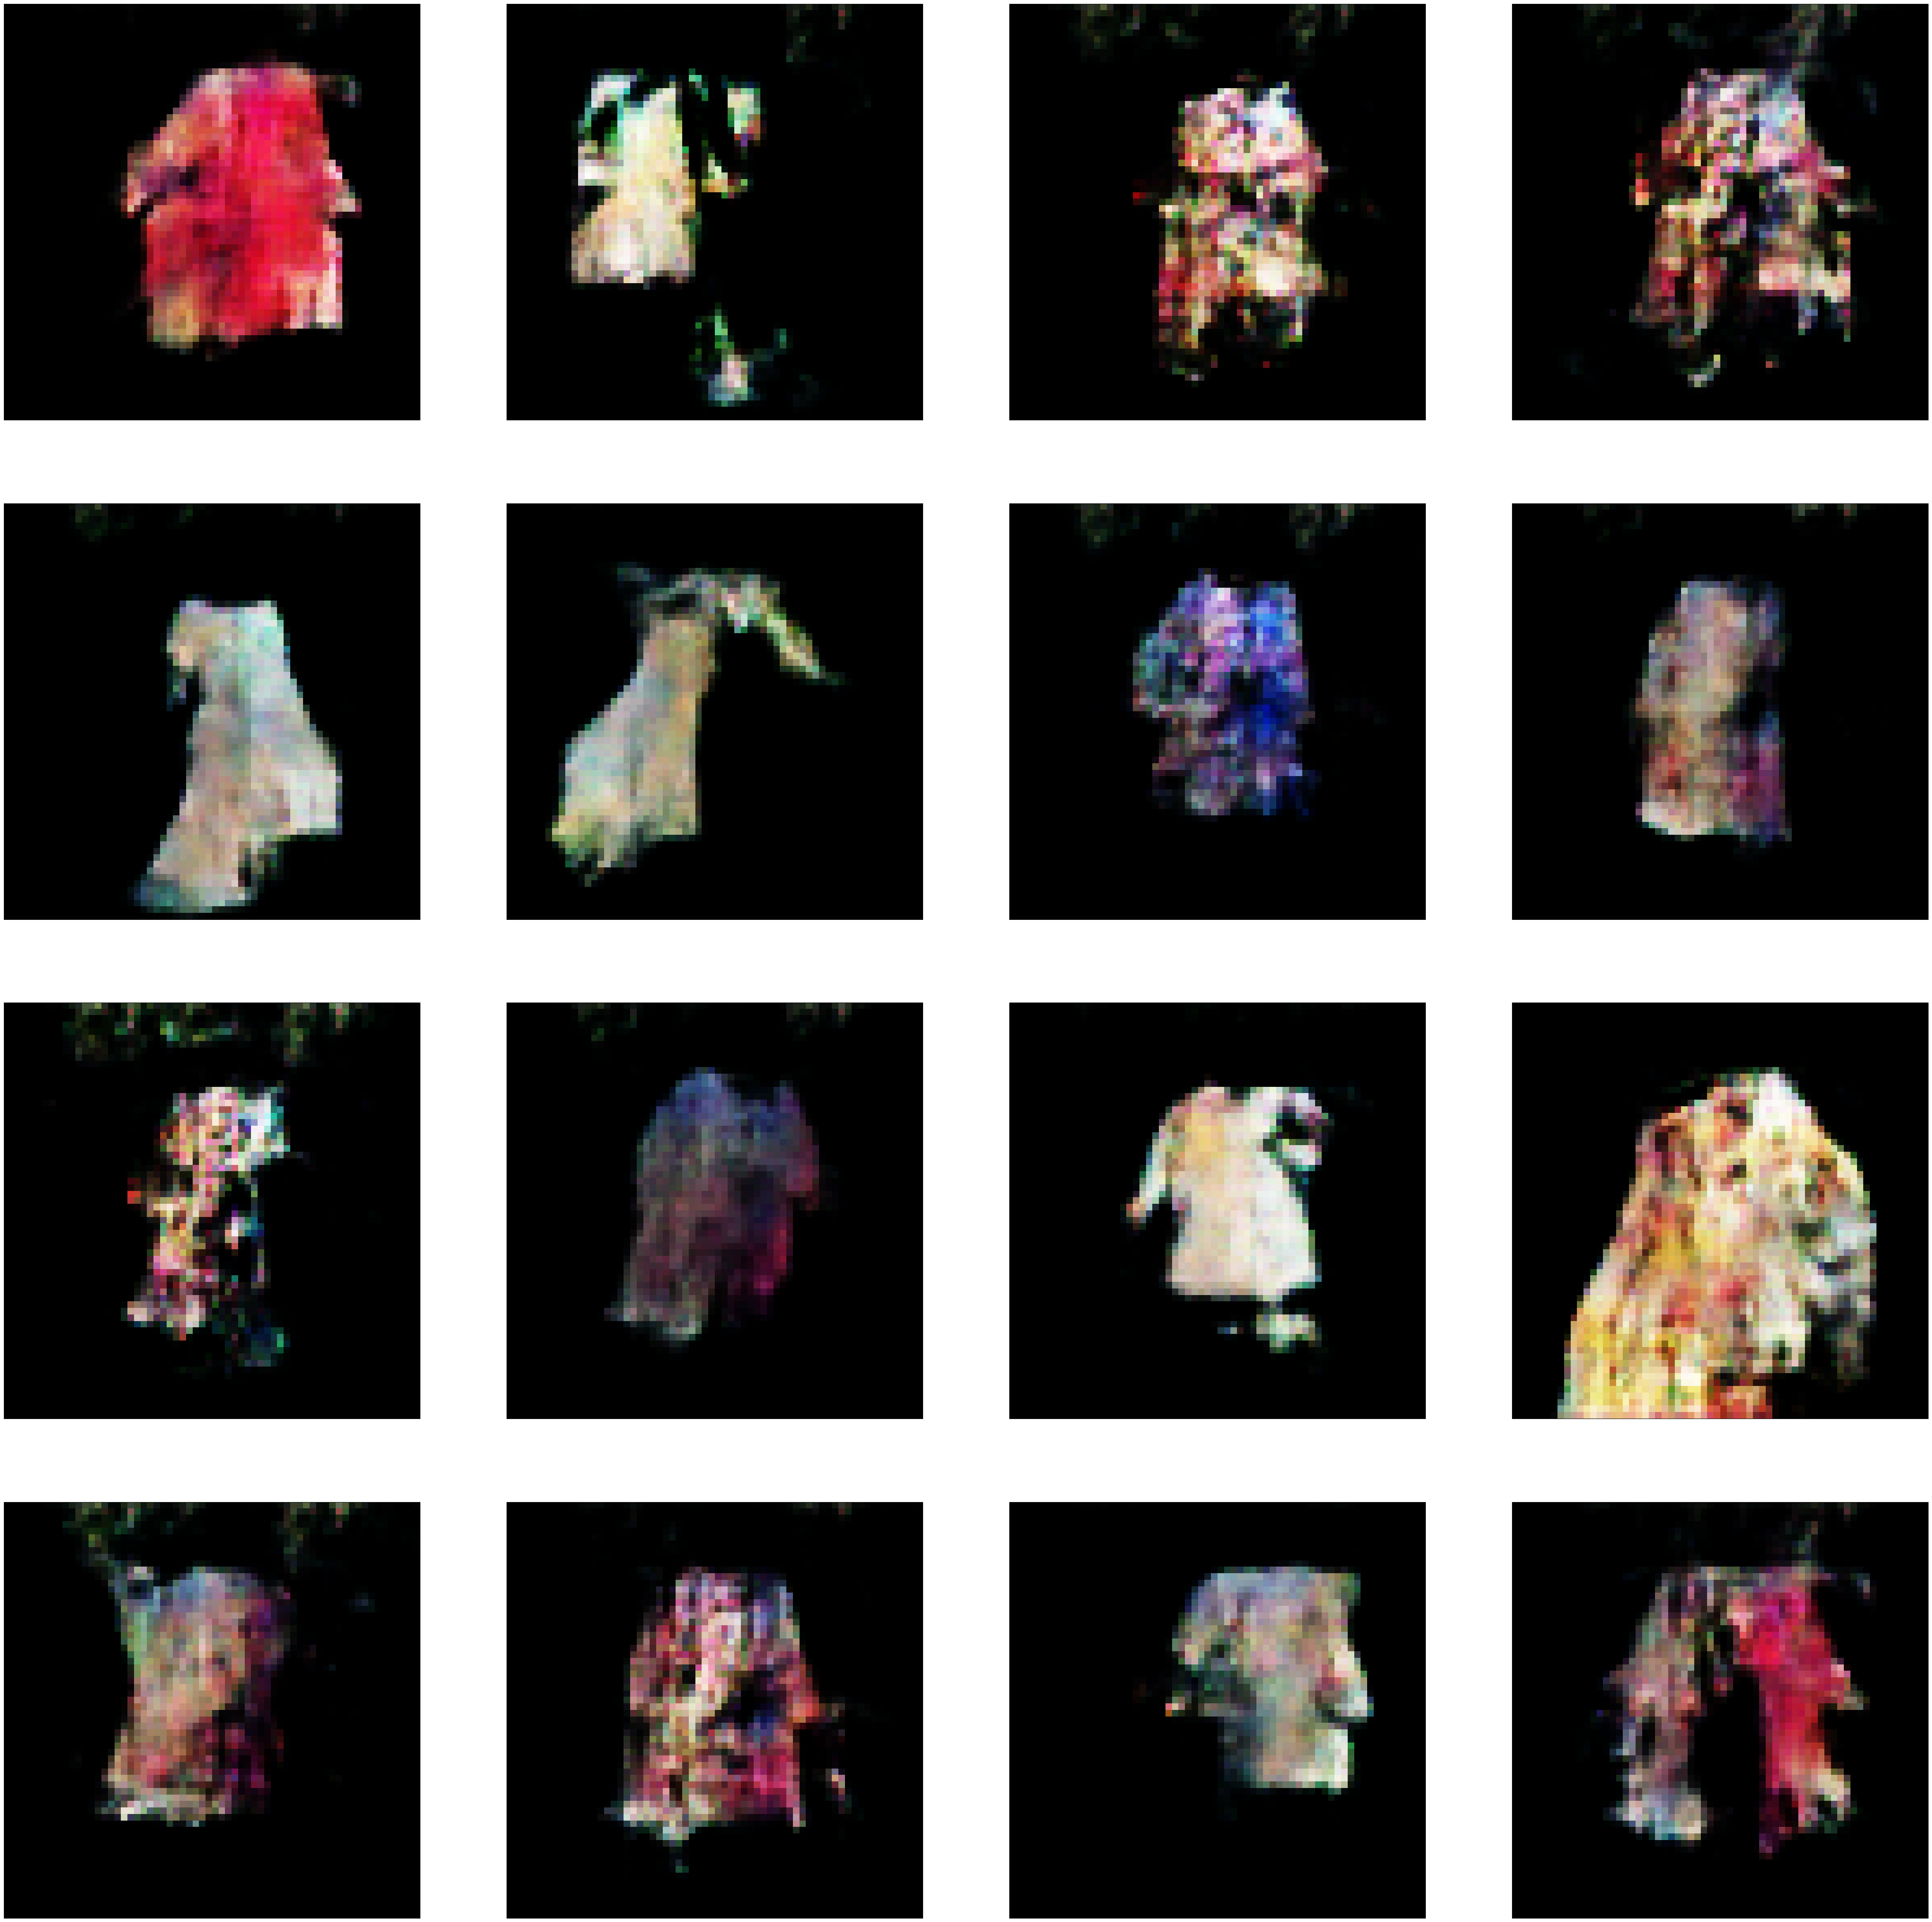

In [25]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
_ = view_samples(16, samples)

# Generating Loss Graph of Discriminator and Generator

* fig, ax = plt.subplots(): Creates a new figure and axis for the plot.
* losses = np.array(losses): Converts the list of loss values to a NumPy array.
* plt.plot(losses.T[0], label='Discriminator', alpha=0.5): Plots the discriminator losses with a transparency of 0.5, using the first column of the losses array. Adds a label 'Discriminator' to the legend.
* plt.plot(losses.T[1], label='Generator', alpha=0.5): Plots the generator losses with a transparency of 0.5, using the second column of the **losses** array. Adds a label 'Generator' to the legend.
* plt.title("Training Losses"): Sets the title of the plot as "Training Losses".
* plt.legend(): Displays the legend indicating which line corresponds to the discriminator and which line corresponds to the generator.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# Testing Function
This section includes the test function to generate samples from the saved weights of generator.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from PIL import Image  # Import PIL library

# Scale function
def Scaling_Func(x, feature_range=(-1, 1)):
    ''' Scalefunction takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
      '''

    # scale x from(0,1) to feature_range and return scaled x
    x = x*2 - 1
    return x

# Define a function to visualize generated samples
# Define a function to visualize generated samples
def visualize_samples(samples, title='Generated Samples'):
    samples = samples.cpu().detach().numpy()
    samples = (samples + 1) / 2.0  # Rescale to (0, 1) range

    num_samples = len(samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))

    for i, ax in enumerate(axes):
        sample = samples[i]
        ax.imshow(np.transpose(sample, (1, 2, 0)))
        ax.axis('off')

    plt.suptitle(title)
    plt.show()


# Define the test function
def test(G, n_samples=10, z_size=200, load_model=True):
    # Load Generator and Discriminator if required
    if load_model:
        save_path = '/content/drive/My Drive/FYP2/ckpts2/'
        try:
            log_file = save_path + "log_file.txt"
            with open(log_file, 'r') as f:
                log_data = f.read()  ## last-saved model number
                print("Loading model #", log_data)
                f.close()

            G_state_dict = torch.load(save_path + 'G_ckpt' + str(log_data) + ".pth")
            G.load_state_dict(G_state_dict)

        except:
            print("No previous model found")
            return

    # Move the Generator to the GPU if available
    G.eval()
    if train_on_gpu:
        G.cuda()

    # Preprocess the input image: scale, resize, and convert to tensor
    # input_image = TF.to_pil_image(input_image)
    # input_image = TF.resize(input_image, (64, 64))
    # input_image = TF.to_tensor(input_image)
    # input_image = Scaling_Func(input_image)
    # if train_on_gpu:
    #     input_image = input_image.cuda()

    # Generate fake samples using the input image
    with torch.no_grad():
        z = np.random.uniform(-1, 1, size=(4, 200))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        random_fake_samples = G(z)

        visualize_samples(random_fake_samples, title='Randomly Generated Fake Samples')

# Load a single input image
# input_image_path = "/content/drive/My Drive/FYP2/random/86_restored.jpg"
# input_image_pil = Image.open(input_image_path).convert('RGB')
# input_image_tensor = TF.to_tensor(input_image_pil)
# input_image_scaled = Scaling_Func(input_image_tensor)
# if train_on_gpu:
#     input_image_scaled = input_image_scaled.cuda()

# Call the test function with the loaded and preprocessed input image
test(G)